# Step 2. Learn peptide representation

Peptides are short fragments of proteins that are generated through enzymatic cleavage within cells. These peptides are then presented on the cell surface by HLA (Human Leukocyte Antigen) molecules, allowing the immune system to scan and monitor the internal state of the cell. Some of these presented peptides can trigger T cell activation, forming the core mechanism of adaptive immune surveillance.

For example, peptides derived from pathogens such as bacteria, viruses, or from cancer cells often differ from those found in normal human cells. When such foreign or abnormal peptides are presented by HLA molecules, they can be recognized by cytotoxic T cells, leading to the targeted killing of infected or malignant cells. However, if self-derived peptides are mistakenly presented and recognized as foreign, this may lead to autoimmune diseases, where the immune system attacks the body’s own healthy tissues.

```{image} ../_static/peptide.png
:alt: 模型结果图
:width: 500px
:align: center

## Load peptide-HLA binding data

Import the necessary libraries and load the peptide-HLA binding data. 

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [2]:
import numpy as np
import torch
import pandas as pd
from trimap import utils
from trimap.model import HLA_vae, PEP_vae
import matplotlib.pyplot as plt


seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

The data is typically in a CSV format, where each row represents a peptide-HLA pair along. We focus on top 20 HLA alleles with the most data points. [Download pmhc_data.csv](https://drive.google.com/file/d/1_rTAQcoxoy-wuv9h4LQSZLmtKkGuaGXz/view?usp=drive_link)

In [3]:
pmhc_data = pd.read_csv('pmhc_data.csv')
counts = pmhc_data['HLA'].value_counts()
pmhc_data = pmhc_data[pmhc_data['HLA'].isin(counts[0:20].index)]
pmhc_data.reset_index(drop=True, inplace=True)
pmhc_data

,Epitope,HLA
0,TQGTPLKY,HLA-A*01:01
1,LDYHMEKY,HLA-A*01:01
2,VTDVGIRY,HLA-A*01:01
3,LVDLRNYQ,HLA-A*01:01
4,LVDDNYFY,HLA-A*01:01
...,...,...
123926,QHQLQQQQL,HLA-B*38:01
123927,LHQQESQSL,HLA-B*38:01
123928,EHANDQQHI,HLA-B*38:01
123929,QHNYPGIKL,HLA-B*38:01


Show the distirbution of epitope length. 9mers are the most common length.

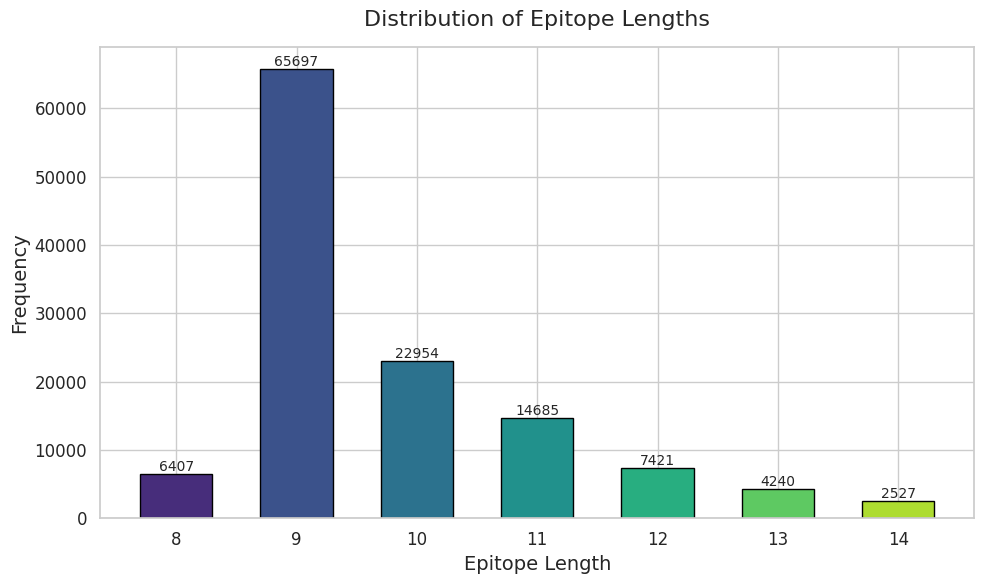

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

epitope_length = pmhc_data['Epitope'].apply(len)
counts = epitope_length.value_counts().sort_index()

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, width=0.6, color=sns.color_palette("viridis", len(counts)), edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Epitope Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Epitope Lengths', fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Load HLA VAE model [Download hla_model.pt](https://drive.google.com/file/d/1ogPnFEfJMdcLLMj5Ky5E__57BeMEeqfG/view?usp=drive_link)

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
hla_model = HLA_vae(input_size=[21, 34], latent_size=256).to(device)
hla_model.load_state_dict(torch.load('hla_model.pt'))

<All keys matched successfully>

Randomly split the data into training and test sets. The training set is used to train the VAE model, while the test set is used to evaluate its performance.

In [6]:
HLA_dict = np.load('hla_dict_34.npy', allow_pickle=True).item()
pmhc_data['HLA_aa'] = pmhc_data['HLA'].str.replace('HLA-', '', regex=False).map(HLA_dict)

In [7]:
phmc_train = pmhc_data.sample(frac=0.8, random_state=seed)
phmc_test = pmhc_data.drop(phmc_train.index)
phmc_train = phmc_train.reset_index(drop=True)
phmc_test = phmc_test.reset_index(drop=True)
print(phmc_train.shape, phmc_test.shape)

df_pmhc_train, peptide_train_tensor, hla_train_tensor = utils.process_phmc(phmc_train,pep_max_len=14,hla_max_len=34)
df_pmhc_test, peptide_test_tensor, hla_test_tensor = utils.process_phmc(phmc_test,pep_max_len=14,hla_max_len=34)

print(peptide_train_tensor.shape, peptide_test_tensor.shape)
print(hla_train_tensor.shape, hla_test_tensor.shape)

(99145, 3) (24786, 3)
torch.Size([99145, 21, 14]) torch.Size([24786, 21, 14])
torch.Size([99145, 21, 34]) torch.Size([24786, 21, 34])


Embed HLA in the training and testing sets using the VAE model.

In [8]:
from torch.utils.data import TensorDataset, DataLoader

def get_loader(tensor, batch_size=256, shuffle=False):
    dataset = TensorDataset(tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

hla_train_loader = get_loader(hla_train_tensor)
hla_test_loader = get_loader(hla_test_tensor)

hla_train_embed, _ = hla_model.embed_hla(hla_train_loader, device)
hla_test_embed, _ = hla_model.embed_hla(hla_test_loader, device)

Create trainloader and testloader for the training and testing sets, respectively.

In [9]:
pmhc_train_dataset = torch.utils.data.TensorDataset(peptide_train_tensor, torch.from_numpy(hla_train_embed))
pmhc_test_dataset = torch.utils.data.TensorDataset(peptide_test_tensor, torch.from_numpy(hla_test_embed))
phmc_train_loader = torch.utils.data.DataLoader(pmhc_train_dataset, batch_size=2048, shuffle=True)

Train the VAE model using the training set. The training process involves optimizing the model parameters to minimize the reconstruction loss of peptide sequences, the align loss with their presenting HLA embeddings, and a KL divergence. The latent space is regularized to follow a Gaussian distribution, which helps in generating diverse and meaningful peptide embeddings. 

In [10]:
input_size = [21, 14]
model = PEP_vae(input_size=input_size,latent_size=256).to(device)
model.train_model(phmc_train_loader, epochs=200, lr=1e-4, device=device)
torch.save(model.state_dict(), 'pep_model.pt')

Epochs: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it, KL_loss=0.1032,align_loss=0.5137,recon_loss=0.8397]


(optional) Load our pre-trained model if needed. [Download here](https://drive.google.com/file/d/13XokCwnWHRxoPGJNc_gDHX8Z9_OhyHZu/view?usp=drive_link)

In [11]:
model.load_state_dict(torch.load('pep_model.pt')) # optional 

<All keys matched successfully>

Embed the training and testing sets using the well-trained model.

In [12]:
dataset = torch.utils.data.ConcatDataset([pmhc_train_dataset, pmhc_test_dataset])
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
result, _ = model.embed_pep(test_loader, device=device)

t-SNE visualization of the embeddings. t-SNE is a dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in a lower-dimensional space (typically 2D or 3D). It helps to reveal the underlying structure of the data and can be useful for identifying clusters or patterns.


In [13]:
from sklearn.manifold import TSNE
all_embed_tsne = TSNE(n_components=2).fit_transform(result)

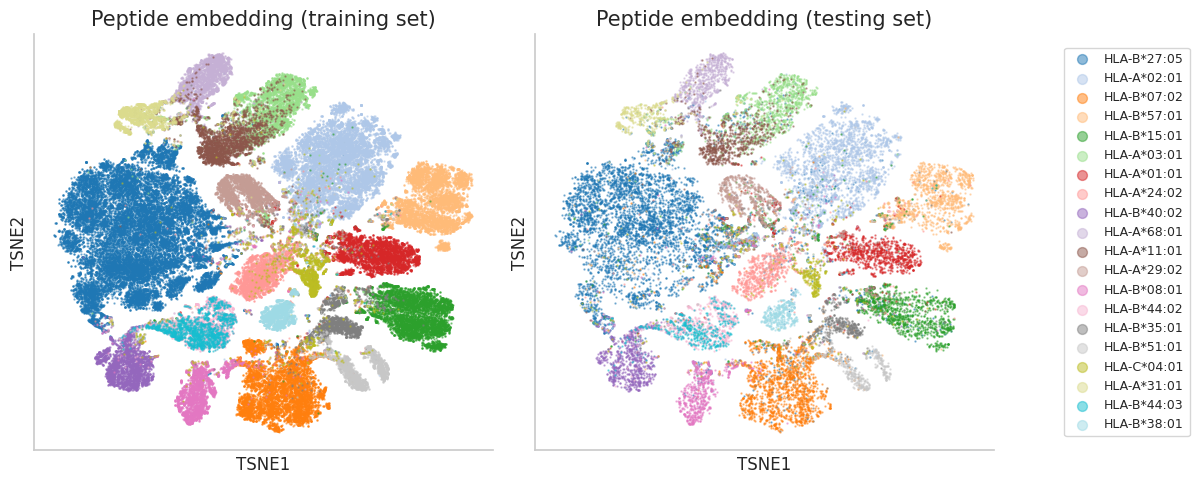

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_peptide_embedding(ax, coords, labels, hla_group, title, alpha=0.3):
    cmap = plt.get_cmap('tab20')
    for label in np.unique(labels):
        ind = np.where(labels == label)[0]
        ax.scatter(
            coords[ind, 0], coords[ind, 1],
            s=0.5, alpha=alpha,
            label=hla_group[label],
            c=[cmap(label / len(hla_group))]
        )
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('TSNE1', fontsize=12)
    ax.set_ylabel('TSNE2', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Prepare data
df_data = pd.concat([df_pmhc_train, df_pmhc_test], axis=0)
counts = df_data['HLA'].value_counts()
hla_group = counts.index.to_list()
hla_labels = torch.tensor([hla_group.index(hla) for hla in df_data['HLA']]).long()
train_labels = hla_labels[:len(df_pmhc_train)]
test_labels = hla_labels[len(df_pmhc_train):]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_peptide_embedding(ax1, all_embed_tsne[:len(df_pmhc_train)], train_labels.numpy(), hla_group, 'Peptide embedding (training set)', alpha=0.5)
plot_peptide_embedding(ax2, all_embed_tsne[len(df_pmhc_train):], test_labels.numpy(), hla_group, 'Peptide embedding (testing set)', alpha=0.5)

# Add legend with larger markers
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=9, markerscale=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Train a KNN classifor on the training set and evaluate its performance on the test set. 

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

train_pep_embed = result[:len(df_pmhc_train)]
test_pep_embed = result[len(df_pmhc_train):]

labels = list(set(df_pmhc_train['HLA'].values)) 
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert train and test labels to integer IDs
train_labels = np.array([label_to_id[label] for label in df_pmhc_train['HLA'].values])
test_labels = np.array([label_to_id[label] for label in df_pmhc_test['HLA'].values])

nn = NearestNeighbors(n_neighbors=100, metric='euclidean')
nn.fit(test_pep_embed)

aa = []
for n_neighbors in [1,5,10,20,30,40,50]:
    # Train a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)  # using 3 neighbors as an example
    knn.fit(train_pep_embed, train_labels)
    # Predict on test set
    predicted_test_labels = knn.predict(test_pep_embed)
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_test_labels)
    print(f"Accuracy: {accuracy * 100:.2f}% for {n_neighbors} neighbors")
    aa.append(accuracy)

Accuracy: 75.54% for 1 neighbors
Accuracy: 78.21% for 5 neighbors
Accuracy: 79.01% for 10 neighbors
Accuracy: 79.75% for 20 neighbors
Accuracy: 79.87% for 30 neighbors
Accuracy: 79.90% for 40 neighbors
Accuracy: 79.94% for 50 neighbors


Calculate a confusion matrix for the KNN classifier's predictions on the test set. The confusion matrix provides a summary of the classification results, showing the number of true positive, true negative, false positive, and false negative predictions.

Accuracy for HLA-B*35:01: 69.34%
Accuracy for HLA-A*11:01: 67.27%
Accuracy for HLA-A*68:01: 87.84%
Accuracy for HLA-B*08:01: 82.35%
Accuracy for HLA-A*02:01: 87.17%
Accuracy for HLA-C*04:01: 54.99%
Accuracy for HLA-A*24:02: 82.69%
Accuracy for HLA-B*38:01: 95.83%
Accuracy for HLA-A*01:01: 85.47%
Accuracy for HLA-B*57:01: 79.69%
Accuracy for HLA-A*31:01: 75.34%
Accuracy for HLA-B*27:05: 81.60%
Accuracy for HLA-B*44:03: 40.87%
Accuracy for HLA-A*29:02: 71.81%
Accuracy for HLA-A*03:01: 76.82%
Accuracy for HLA-B*51:01: 71.06%
Accuracy for HLA-B*44:02: 73.32%
Accuracy for HLA-B*07:02: 86.61%
Accuracy for HLA-B*40:02: 87.88%
Accuracy for HLA-B*15:01: 74.90%


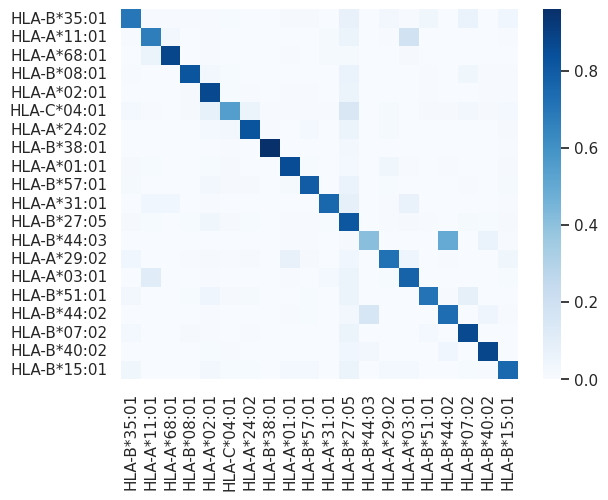

In [16]:
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix
cm = confusion_matrix(test_labels, predicted_test_labels)

# Calculate accuracy for each label
label_accuracies = {}
for i, label in id_to_label.items():
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    label_accuracies[label] = true_positives / total_samples

for label, accuracy in label_accuracies.items():
    print(f"Accuracy for {label}: {accuracy * 100:.2f}%")

# Row normalization
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Create a heatmap of the normalized confusion matrix
sns.heatmap(normalized_cm, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.show()